### Notebook: Learning Authenticated Encryption With Adversarial Neural Cryptography

Based on the content from the following [git repository](https://github.com/mguarin0/LearningToProtectCommunicationsWithAdversarialNeuralCryptography) by Michael Guarino, we try to construct neural networks - Bob and Alice - that are capable of signing and encrypting communication (authenticated encryption), such that an adversarial network - Eve - can not forge a valid authentication code or reconstruct the encrypted message.

<img src="src/setup.png">

We start by defining certain hyperparameters that are used throughout the notebook. 

In [1]:
import torch

# define the message and signature length
n = 16
# define the number of training steps 
training_steps = 25000                   
# define the mini-batch size (training examples per batch)
batch_size = 256
# define the learning_rate",
learning_rate = 0.0005
# during training print output to cli every n steps
show_every_n_steps = 100
# checkpoint model files during training every n epochs
checkpoint_every_n_steps = 5000
# during training print model outputs to cli
verbose = False
# maximum allowed value of the gradients in range(-clip_value, clip_value)
clip_value = 1

# determine if gpu present
if torch.cuda.device_count() > 0:
    gpu_available = True
else:
    gpu_available = False

Now that we have the important parameters of our networks set, let's define the network architectures. We use a mix and transform architecture (FC-layer + conv-layers).

In [2]:
import torch

# Network architecture 1 (for an output of 2n)
class MixTransformNN(torch.nn.Module):
    def __init__(self, D_in, H):

        super(MixTransformNN, self).__init__()

        # first fully-connected layer
        self.fc_layer = torch.nn.Linear(D_in, H)

        # sequence of convolutional layers 
        self.conv1 = torch.nn.Conv1d(in_channels=1,
                                     out_channels=2,
                                     kernel_size=2,
                                     stride=1)

        self.conv2 = torch.nn.Conv1d(in_channels=2,
                                     out_channels=4,
                                     kernel_size=1,
                                     stride=2)

        self.conv3 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=4,
                                     kernel_size=2,
                                     stride=2)

        self.conv4 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=1,
                                     kernel_size=1,
                                     stride=1)


    def forward(self, x):

        x = x[None, :, :].transpose(0, 1)

        # apply non-linearity (sigmoid) right after convolution and FC layer
        x = torch.relu(self.fc_layer(x))

        x = torch.relu(self.conv1(x))

        x = torch.relu(self.conv2(x))

        x = torch.relu(self.conv3(x))

        # output domain between [-1,1] can be easily mapped back to bits
        x = torch.tanh(self.conv4(x))

        # returns a tensor with all the dimensions of input of size 1 removed
        return torch.squeeze(x)

In [4]:
# Network architecture 2 (for an output of n)
class Al_MixTransformNN(torch.nn.Module):
    def __init__(self, D_in, H):

        super(Al_MixTransformNN, self).__init__()

        # first fully-connected layer
        self.fc_layer = torch.nn.Linear(D_in, H)

        # sequence of convolutional layers 
        self.conv1 = torch.nn.Conv1d(in_channels=1,
                                     out_channels=2,
                                     kernel_size=1,
                                     stride=1,
                                     padding=2)

        self.conv2 = torch.nn.Conv1d(in_channels=2,
                                     out_channels=4,
                                     kernel_size=1,
                                     stride=2,
                                     padding=2)

        self.conv3 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=4,
                                     kernel_size=1,
                                     stride=1,
                                     padding=2)

        self.conv4 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=1,
                                     kernel_size=1,
                                     stride=1)

    def forward(self, x):

        x = x[None, :, :].transpose(0, 1)

        # apply non-linearity (sigmoid) right after convolution and FC layer
        x = torch.relu(self.fc_layer(x))

        x = torch.relu(self.conv1(x))

        x = torch.relu(self.conv2(x))

        x = torch.relu(self.conv3(x))

        # output domain between [-1,1] can be easily mapped back to bits
        x = torch.tanh(self.conv4(x))

        # returns a tensor with all the dimensions of input of size 1 removed
        return torch.squeeze(x)

Finally, we need to construct a network architecture for the Bob discriminator. It needs to discriminate between a valid and a forged signature. 

In [5]:
# Bob network architecture (for an output of 1 [between 0 and 1])
class Discriminator(torch.nn.Module):
    def __init__(self, D_in, H):

        super(Discriminator, self).__init__()

        # first fully-connected layer
        self.fc_layer = torch.nn.Linear(D_in, H)

        # sequence of convolutional layers 
        self.conv1 = torch.nn.Conv1d(in_channels=1,
                                     out_channels=2,
                                     kernel_size=4,
                                     stride=2,
                                     padding=2)

        self.conv2 = torch.nn.Conv1d(in_channels=2,
                                     out_channels=4,
                                     kernel_size=2,
                                     stride=2)

        self.conv3 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=6,
                                     kernel_size=1,
                                     stride=2)

        self.conv4 = torch.nn.Conv1d(in_channels=6,
                                     out_channels=4,
                                     kernel_size=4,
                                     stride=2)

        self.conv5 = torch.nn.Conv1d(in_channels=4,
                                     out_channels=1,
                                     kernel_size=2,
                                     stride=2)


    def forward(self, x):

        x = x[None, :, :].transpose(0, 1)

        # apply non-linearity (sigmoid) right after convolution and FC layer
        x = torch.relu(self.fc_layer(x))

        x = torch.relu(self.conv1(x))

        x = torch.relu(self.conv2(x))
    
        x = torch.relu(self.conv3(x))

        x = torch.relu(self.conv4(x))

        x = torch.sigmoid(self.conv5(x))

        # returns a tensor with all the dimensions of input of size 1 removed
        return torch.squeeze(x)

Next, let's introduce some mechanisms for persistently storing and restoring the trained neural networks. 

In [6]:
import pickle

def persist_object(full_path, x):
    with open(full_path, "wb") as file:
        pickle.dump(x, file)

def restore_persist_object(full_path):
    with open(full_path, "rb") as file:
        x = pickle.load(file)
    return x

As well as some mechanisms for generating random bitstrings for the messages and keys of length n.

In [7]:
def generate_data(gpu_available, batch_size, n):
    if gpu_available:
        return [torch.randint(0, 2, (batch_size, n), dtype=torch.float).cuda()*2-1,
                torch.randint(0, 2, (batch_size, 2*n), dtype=torch.float).cuda()*2-1]
    else:
        return [torch.randint(0, 2, (batch_size, n), dtype=torch.float)*2-1,
                torch.randint(0, 2, (batch_size, 2*n), dtype=torch.float)*2-1]

And a class that contains all important relative paths.

In [8]:
import os

class prjPaths:
    def __init__(self, getDataset=True):
        self.SRC_DIR = os.path.abspath(os.path.curdir)
        self.ROOT_MOD_DIR = "/".join(self.SRC_DIR.split("/")[:-1])
        self.LIB_DIR = os.path.join(self.ROOT_MOD_DIR, "lib")
        self.CHECKPOINT_DIR = os.path.join(self.LIB_DIR, "chkpts")
        self.PERSIST_DIR = os.path.join(self.LIB_DIR, "persist")

        pth_exists_else_mk = lambda path: os.mkdir(path) if not os.path.exists(path) else None

        pth_exists_else_mk(self.LIB_DIR)
        pth_exists_else_mk(self.CHECKPOINT_DIR)
        pth_exists_else_mk(self.PERSIST_DIR)

prjPaths_ = prjPaths()

Also, we want to delete the previously stored networks and other files when starting a new training session. 

In [9]:
def clean_cache(prjPaths):
    # all checkpoints
    for root, dirs, files in os.walk(prjPaths.CHECKPOINT_DIR):
        for file in files:
            os.remove(os.path.join(root, file))
    # all persist data
        for root, dirs, files in os.walk(prjPaths.PERSIST_DIR):
            for file in files:
                os.remove(os.path.join(root, file))

Now before we introduce the training procedure, we first define the loss. The training procedure is a min-max game between Alice_Bob and Eve. Bob is supposed to learn the reconstruction of a correctly authenticated ciphertext A(P,K) and the discrimination between a correctly authenticated ciphertext A(P,K) and a forged authenticated ciphertext E(P) by returning either 0 for the valid case and 1 for the forged ciphertext. Formally, Alice_Bob need to minimize B(P,A(P,K),K) and to maximize B(P,E(P),K), while Eve needs to do the opposite. 
In addition to that, Bob wants to minimize the reconstruction error d(P,B(A(P,K),K)), while maximizing the reconstruction error of Eve d(P,E(A(P,K))).

<img src="src/loss.png">

In [10]:
from torch.optim import Adam
import time

def train(aggregated_losses_every_n_steps=100):

    # clean previously stored files
    clean_cache(prjPaths_)

    # define networks
    alice = Al_MixTransformNN(D_in=(n*3), H=(n*3))
    eve_forge = Al_MixTransformNN(D_in=(n), H=(n*3))
    eve_decr = MixTransformNN(D_in=(2*n), H=(n*4))
    bob_vrfy = Discriminator(D_in=(4*n), H=(4*n))
    bob_decr = MixTransformNN(D_in=(n*4), H=(n*4))

    # specify that model is currently in training mode
    alice.train()
    bob_vrfy.train()
    bob_decr.train()
    eve_forge.train()
    eve_decr.train()

    if gpu_available:
        alice.cuda()
        bob_vrfy.cuda()
        bob_decr.train()
        eve_forge.cuda()
        eve_decr.cuda()

    # pickle n (message length)
    persist_object(full_path=os.path.join(prjPaths_.PERSIST_DIR, "n.p"), x=n)

    # aggregate training errors
    aggregated_losses = {
            "alice_bob_vrfy_loss": [],
            "eve_bob_vrfy_loss": [],
            "output_bob_vrfy": [],
            "alice_bob_training_loss": [],
            "bob_reconstruction_training_errors": [],
            "eve_reconstruction_training_errors": [],
            "step": [],
            "alice_bob_equivalence": [],
            "alice_key_equivalence": []
    }

    # define optimizers
    optimizer_alice = Adam(params=alice.parameters(), lr=learning_rate)
    optimizer_bob_vrfy = Adam(params=bob_vrfy.parameters(), lr=learning_rate)
    optimizer_bob_decr = Adam(params=bob_decr.parameters(), lr=learning_rate)
    optimizer_eve_forge = Adam(params=eve_forge.parameters(), lr=learning_rate)
    optimizer_eve_decr = Adam(params=eve_decr.parameters(), lr=learning_rate)

    # define loss 
    criterion = torch.nn.BCELoss()
    d = torch.nn.L1Loss()
    bob_reconstruction_error = torch.nn.L1Loss()
    eve_reconstruction_error = torch.nn.L1Loss()

    # define phase var
    eve_var = 1

    # training loop
    for step in range(training_steps+1):

        # start time for step
        tic = time.time()

        # Training alternates between Alice/Bob and Eve
        for network, num_minibatches in {"alice_bob": 1, "eve": eve_var}.items():

            """ 
            Alice/Bob training for one minibatch, and then Eve training for two minibatches this ratio 
            in order to give a slight computational edge to the adversary Eve without training it so much
            that it becomes excessively specific to the exact current parameters of Alice and Bob
            """
            for minibatch in range(num_minibatches):
                # generate random message and key
                m, k = generate_data(gpu_available=gpu_available, batch_size=batch_size, n=n)

                # forward pass through alice and eve networks
                alice_o = alice.forward(torch.cat((m, k), 1).float())
                evo_forge_o = eve_forge.forward(m)
                eve_decr_o = eve_decr.forward(alice_o)

                # if network == "alice_bob":
                # train real generator and discriminator 
                if network == "alice_bob":

                    ################
                    # BOB_VRFY LOSS
                    ################

                    # forward pass through bob network: real sig 
                    real_targets = torch.zeros(batch_size)
                    bob_vrfy_real = bob_vrfy.forward(torch.cat((alice_o, k), 1).float())
                    vrfy_real_loss = criterion(bob_vrfy_real, real_targets)

                    # forward pass through bob network: false sig 
                    fake_targets = torch.ones(batch_size)
                    bob_vrfy_fake = bob_vrfy.forward(torch.cat((evo_forge_o, k), 1).float())
                    vrfy_fake_loss = criterion(bob_vrfy_fake, fake_targets)

                    # calculate errors
                    alice_bob_loss_sign =  0.5 * (vrfy_real_loss + vrfy_fake_loss)

                    ################
                    # BOB_DECR LOSS
                    ################

                    bob_decr_real = bob_decr.forward(torch.cat((alice_o, k), 1).float())
                    error_bob = bob_reconstruction_error(input=bob_decr_real, target=m)
                    error_eve = eve_reconstruction_error(input=eve_decr_o, target=m)
                    alice_bob_loss_decr =  error_bob + (1 - error_eve**2) 

                    ################
                    # TOTAL LOSS
                    ################

                    total_loss = alice_bob_loss_sign + alice_bob_loss_decr

                    # equivalene
                    alice_key_equivalence = d(alice_o, k)
                    alice_bob_equivalence = d(alice_o, evo_forge_o)

                    ################
                    # TRAINING
                    ################

                    # Zero gradients, perform a backward pass, clip gradients, and update the weights.
                    optimizer_alice.zero_grad()
                    optimizer_bob_decr.zero_grad()
                    optimizer_bob_vrfy.zero_grad()
                    total_loss.backward()
                    torch.nn.utils.clip_grad_value_(alice.parameters(), clip_value)
                    torch.nn.utils.clip_grad_value_(bob_decr.parameters(), clip_value)
                    torch.nn.utils.clip_grad_value_(bob_vrfy.parameters(), clip_value)
                    optimizer_alice.step()
                    optimizer_bob_decr.step()
                    optimizer_bob_vrfy.step()
                    
                    ################
                    # PHASE 2, if one score is met 
                    ################
                    if step > 15000:
                        eve_var = 4 

                #elif network == "eve":
                elif network == "eve":

                    ################
                    # EVE_DECR LOSS
                    ################

                    error_eve = eve_reconstruction_error(input=eve_decr_o, target=m)

                    ################
                    # TRAINING: DECR
                    ################

                    # Zero gradients, perform a backward pass, and update the weights
                    optimizer_eve_decr.zero_grad()
                    error_eve.backward(retain_graph=True)
                    torch.nn.utils.clip_grad_value_(eve_decr.parameters(), clip_value)
                    optimizer_eve_decr.step()

                    ################
                    # EVE_FORGE LOSS
                    ################

                    # forward pass through bob network
                    bob_o = bob_vrfy.forward(torch.cat((evo_forge_o, k), 1).float())

                    # calculate errors: fool network
                    eve_forge_loss = criterion(bob_o, real_targets)
                    
                    # equivalene
                    alice_key_equivalence = d(alice_o, k)
                    alice_bob_equivalence = d(alice_o, evo_forge_o)

                    ################
                    # TRAINING: SIGN
                    ################

                    # Zero gradients, perform a backward pass, and update the weights
                    optimizer_eve_forge.zero_grad()
                    eve_forge_loss.backward()
                    torch.nn.utils.clip_grad_value_(eve_forge.parameters(), clip_value)
                    optimizer_eve_forge.step()

        # end time time for step
        time_elapsed = time.time() - tic

        if step % aggregated_losses_every_n_steps == 0:
            # aggregate min training errors for bob and eve networks
            aggregated_losses["alice_bob_vrfy_loss"].append(alice_bob_loss_sign.cpu().detach().numpy().tolist())
            aggregated_losses["eve_bob_vrfy_loss"].append(eve_forge_loss.cpu().detach().numpy().tolist())
            aggregated_losses["alice_bob_equivalence"].append(alice_bob_equivalence.cpu().detach().numpy().tolist())
            aggregated_losses["alice_key_equivalence"].append(alice_key_equivalence.cpu().detach().numpy().tolist())
            aggregated_losses["step"].append(step)

            aggregated_losses["alice_bob_training_loss"].append(alice_bob_loss_decr.cpu().detach().numpy().tolist())
            aggregated_losses["bob_reconstruction_training_errors"].append(error_bob.cpu().detach().numpy().tolist())
            aggregated_losses["eve_reconstruction_training_errors"].append(error_eve.cpu().detach().numpy().tolist())

        if step % show_every_n_steps == 0:
            print("Total_Steps: %i of %i || Time_Elapsed_Per_Step: (%.3f sec/step) || Bob_Alice_Loss: %.5f || Bob_Reconstruction_Error: %.5f || Eve_Reconstruction_Error: %.5f" % (step,
                                                                                                                                                                                   training_steps,
                                                                                                                                                                                   time_elapsed,
                                                                                                                                                                                   aggregated_losses["alice_bob_training_loss"][-1],
                                                                                                                                                                                   aggregated_losses["bob_reconstruction_training_errors"][-1],
                                                                                                                                                                                   aggregated_losses["eve_reconstruction_training_errors"][-1]))

            print("alice_bob_vrfy_loss: %.5f || eve_bob_verfy_loss: %.5f || distance alice_bob: %.5f || distance alice_key: %.5f " % (aggregated_losses["alice_bob_vrfy_loss"][-1],
                                                                                                    aggregated_losses["eve_bob_vrfy_loss"][-1],
                                                                                                     aggregated_losses["alice_bob_equivalence"][-1],
                                                                                                    aggregated_losses["alice_key_equivalence"][-1]))

            print()                                                                                                                                                                      

        if step % checkpoint_every_n_steps == 0 and step != 0:
            print("checkpointing models...\n")
            torch.save(alice.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "alice.pth"))
            torch.save(bob_vrfy.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "bob_vrfy.pth"))
            torch.save(bob_decr.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "bob_decr.pth"))
            torch.save(eve_forge.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "eve_forge.pth"))
            torch.save(eve_decr.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "eve_decr.pth"))

    # pickle aggregated list of errors
    persist_object(full_path=os.path.join(prjPaths_.PERSIST_DIR, "aggregated_losses.p"), x=aggregated_losses)

In [12]:
train()

Total_Steps: 0 of 25000 || Time_Elapsed_Per_Step: (0.044 sec/step) || Bob_Alice_Loss: 0.98785 || Bob_Reconstruction_Error: 1.00002 || Eve_Reconstruction_Error: 0.99876
alice_bob_vrfy_loss: 0.70484 || eve_bob_verfy_loss: 0.55250 || distance alice_bob: 0.33856 || distance alice_key: 0.99663 

Total_Steps: 100 of 25000 || Time_Elapsed_Per_Step: (0.034 sec/step) || Bob_Alice_Loss: 1.00247 || Bob_Reconstruction_Error: 0.99997 || Eve_Reconstruction_Error: 1.00047
alice_bob_vrfy_loss: 0.68668 || eve_bob_verfy_loss: 0.61530 || distance alice_bob: 0.32265 || distance alice_key: 1.00206 

Total_Steps: 200 of 25000 || Time_Elapsed_Per_Step: (0.034 sec/step) || Bob_Alice_Loss: 0.99633 || Bob_Reconstruction_Error: 0.99974 || Eve_Reconstruction_Error: 0.99335
alice_bob_vrfy_loss: 0.63525 || eve_bob_verfy_loss: 0.71002 || distance alice_bob: 0.27971 || distance alice_key: 0.99473 

Total_Steps: 300 of 25000 || Time_Elapsed_Per_Step: (0.035 sec/step) || Bob_Alice_Loss: 0.99679 || Bob_Reconstruction_Er

Let's now plot the results.

In [13]:
with open(os.path.join(prjPaths_.PERSIST_DIR, "aggregated_losses.p"), "rb") as file:
    aggregated_losses = pickle.load(file)

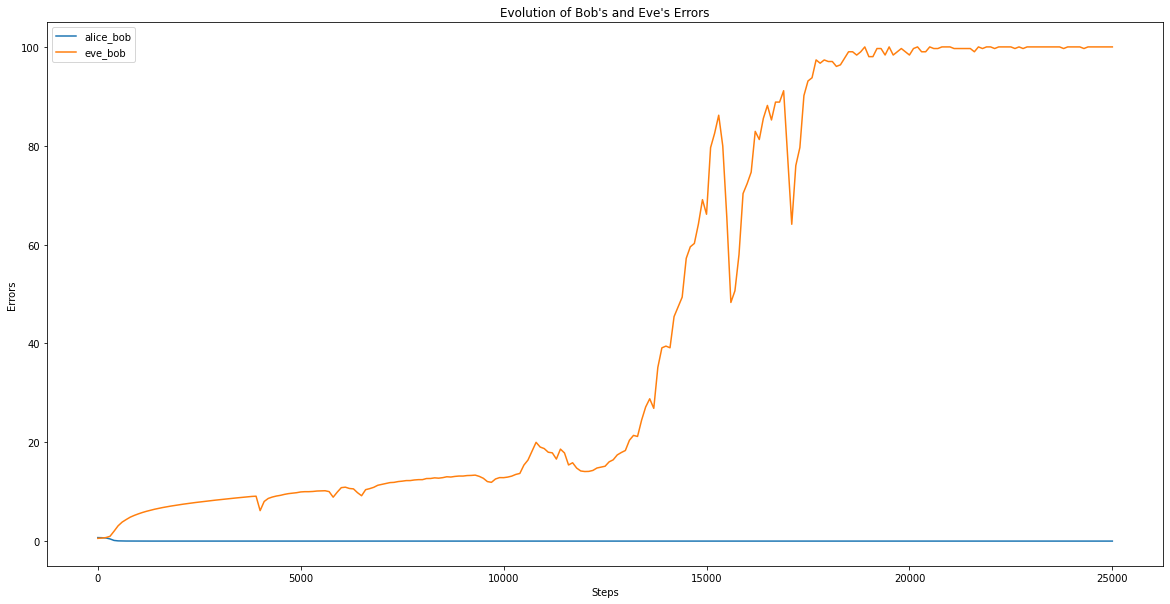

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["alice_bob_vrfy_loss"], label="alice_bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_bob_vrfy_loss"], label="eve_bob")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Errors")

plt.show()

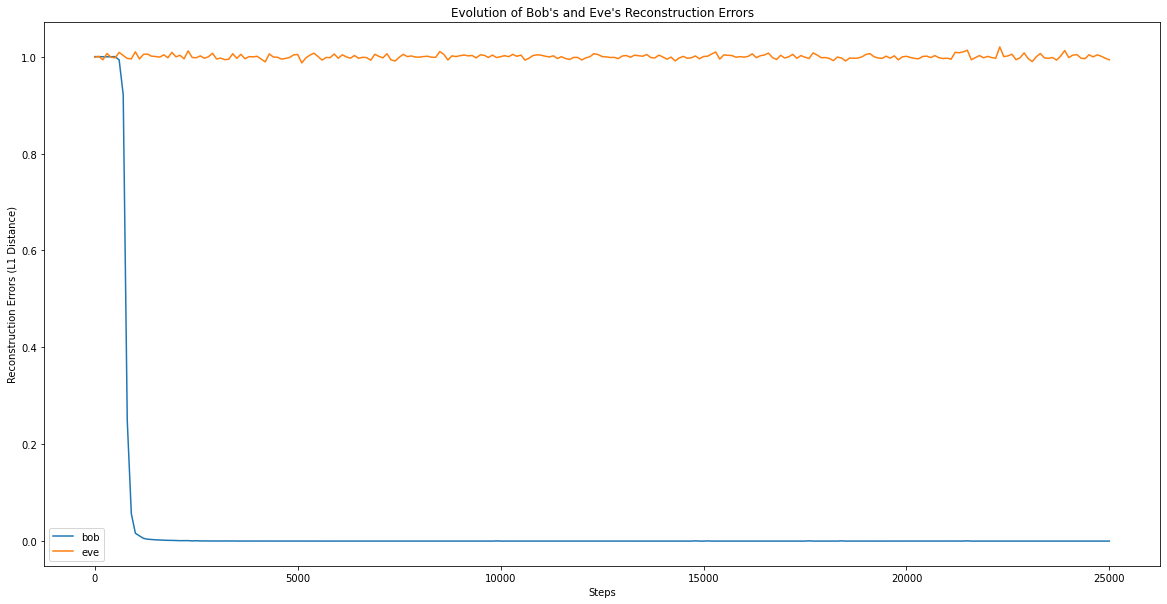

In [15]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["bob_reconstruction_training_errors"], label="bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_reconstruction_training_errors"], label="eve")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Reconstruction Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Reconstruction Errors (L1 Distance)")

plt.show()

We exclusively train eve a few iterations further, such that it could learn the authenticated encryption scheme in case of a vulnerability. 

In [16]:
training_steps = 5000
def train_eve(aggregated_losses_every_n_steps=100):
    
    # restore variable to describe message length used to determine network dimensions
    n = restore_persist_object(full_path=os.path.join(prjPaths_.PERSIST_DIR, "n.p"))

    # define networks
    alice = Al_MixTransformNN(D_in=(n*3), H=(n*3))
    eve_forge = Al_MixTransformNN(D_in=(n), H=(n*3))
    eve_decr = MixTransformNN(D_in=(2*n), H=(n*4))
    bob_vrfy = Discriminator(D_in=(4*n), H=(4*n))
    bob_decr = MixTransformNN(D_in=(n*4), H=(n*4))

    # reload eve 
    print("restoring all networks...\n")
    alice.load_state_dict(torch.load(os.path.join(prjPaths_.CHECKPOINT_DIR, "alice.pth")))
    bob_vrfy.load_state_dict(torch.load(os.path.join(prjPaths_.CHECKPOINT_DIR, "bob_vrfy.pth")))
    bob_decr.load_state_dict(torch.load(os.path.join(prjPaths_.CHECKPOINT_DIR, "bob_decr.pth")))
    eve_forge.load_state_dict(torch.load(os.path.join(prjPaths_.CHECKPOINT_DIR, "eve_forge.pth")))
    eve_decr.load_state_dict(torch.load(os.path.join(prjPaths_.CHECKPOINT_DIR, "eve_decr.pth")))

    # specify that only the eve model is currently in training mode
    alice.eval()
    bob_vrfy.eval()
    bob_decr.eval()
    eve_forge.train()
    eve_decr.train()

    if gpu_available:
        alice.cuda()
        bob_vrfy.cuda()
        bob_decr.train()
        eve_forge.cuda()
        eve_decr.cuda()

    # aggregate training errors
    aggregated_losses = {
            "alice_bob_vrfy_loss": [],
            "eve_bob_vrfy_loss": [],
            "output_bob_vrfy": [],
            "alice_bob_training_loss": [],
            "bob_reconstruction_training_errors": [],
            "eve_reconstruction_training_errors": [],
            "step": [],
            "alice_bob_equivalence": [],
            "alice_key_equivalence": []
    }

    # define optimizers
    optimizer_eve_forge = Adam(params=eve_forge.parameters(), lr=learning_rate)
    optimizer_eve_decr = Adam(params=eve_decr.parameters(), lr=learning_rate)

    # define loss 
    criterion = torch.nn.BCELoss()
    d = torch.nn.L1Loss()
    bob_reconstruction_error = torch.nn.L1Loss()
    eve_reconstruction_error = torch.nn.L1Loss()

    # training loop
    for step in range(training_steps+1):

        # start time for step
        tic = time.time()

        # Training alternates between Alice/Bob and Eve
        for network, num_minibatches in {"alice_bob": 0, "eve": 1}.items():

            """ 
            Alice/Bob training for one minibatch, and then Eve training for two minibatches this ratio 
            in order to give a slight computational edge to the adversary Eve without training it so much
            that it becomes excessively specific to the exact current parameters of Alice and Bob
            """
            for minibatch in range(num_minibatches):
                # generate random message and key
                m, k = generate_data(gpu_available=gpu_available, batch_size=batch_size, n=n)

                # forward pass through alice and eve networks
                alice_o = alice.forward(torch.cat((m, k), 1).float())
                evo_forge_o = eve_forge.forward(m)
                eve_decr_o = eve_decr.forward(alice_o)

                # train eve

                # forward pass through bob network: real sig 
                real_targets = torch.zeros(batch_size)
                bob_vrfy_real = bob_vrfy.forward(torch.cat((alice_o, k), 1).float())
                vrfy_real_loss = criterion(bob_vrfy_real, real_targets)

                # forward pass through bob network: false sig 
                fake_targets = torch.ones(batch_size)
                bob_vrfy_fake = bob_vrfy.forward(torch.cat((evo_forge_o, k), 1).float())
                vrfy_fake_loss = criterion(bob_vrfy_fake, fake_targets)

                # calculate errors
                alice_bob_loss_sign =  0.5 * (vrfy_real_loss + vrfy_fake_loss)

                ################
                # BOB_DECR LOSS
                ################

                bob_decr_real = bob_decr.forward(torch.cat((alice_o, k), 1).float())
                error_bob = bob_reconstruction_error(input=bob_decr_real, target=m)
                error_eve = eve_reconstruction_error(input=eve_decr_o, target=m)
                alice_bob_loss_decr =  error_bob + (1 - error_eve**2)

                ################
                # TOTAL LOSS
                ################

                total_loss = alice_bob_loss_sign + alice_bob_loss_decr

                # equivalene
                alice_key_equivalence = d(alice_o, k)
                alice_bob_equivalence = d(alice_o, evo_forge_o)

                ################
                # EVE_DECR LOSS
                ################

                error_eve = eve_reconstruction_error(input=eve_decr_o, target=m)

                ################
                # TRAINING: DECR
                ################

                # Zero gradients, perform a backward pass, and update the weights
                optimizer_eve_decr.zero_grad()
                error_eve.backward(retain_graph=True)
                torch.nn.utils.clip_grad_value_(eve_decr.parameters(), clip_value)
                optimizer_eve_decr.step()

                ################
                # EVE_FORGE LOSS
                ################

                # forward pass through bob network
                bob_o = bob_vrfy.forward(torch.cat((evo_forge_o, k), 1).float())

                # calculate errors: fool network
                eve_forge_loss = criterion(bob_o, real_targets)
                
                # equivalene
                alice_key_equivalence = d(alice_o, k)
                alice_bob_equivalence = d(alice_o, evo_forge_o)

                ################
                # TRAINING: SIGN
                ################

                # Zero gradients, perform a backward pass, and update the weights
                optimizer_eve_forge.zero_grad()
                eve_forge_loss.backward()
                torch.nn.utils.clip_grad_value_(eve_forge.parameters(), clip_value)
                optimizer_eve_forge.step()

        # end time time for step
        time_elapsed = time.time() - tic

        if step % aggregated_losses_every_n_steps == 0:
            # aggregate min training errors for bob and eve networks
            aggregated_losses["alice_bob_vrfy_loss"].append(alice_bob_loss_sign.cpu().detach().numpy().tolist())
            aggregated_losses["eve_bob_vrfy_loss"].append(eve_forge_loss.cpu().detach().numpy().tolist())
            aggregated_losses["alice_bob_equivalence"].append(alice_bob_equivalence.cpu().detach().numpy().tolist())
            aggregated_losses["alice_key_equivalence"].append(alice_key_equivalence.cpu().detach().numpy().tolist())
            aggregated_losses["step"].append(step)

            aggregated_losses["alice_bob_training_loss"].append(alice_bob_loss_decr.cpu().detach().numpy().tolist())
            aggregated_losses["bob_reconstruction_training_errors"].append(error_bob.cpu().detach().numpy().tolist())
            aggregated_losses["eve_reconstruction_training_errors"].append(error_eve.cpu().detach().numpy().tolist())

        if step % show_every_n_steps == 0:
            print("Total_Steps: %i of %i || Time_Elapsed_Per_Step: (%.3f sec/step) || Bob_Alice_Loss: %.5f || Bob_Reconstruction_Error: %.5f || Eve_Reconstruction_Error: %.5f" % (step,
                                                                                                                                                                                   training_steps,
                                                                                                                                                                                   time_elapsed,
                                                                                                                                                                                   aggregated_losses["alice_bob_training_loss"][-1],
                                                                                                                                                                                   aggregated_losses["bob_reconstruction_training_errors"][-1],
                                                                                                                                                                                   aggregated_losses["eve_reconstruction_training_errors"][-1]))

            print("alice_bob_vrfy_loss: %.5f || eve_bob_verfy_loss: %.5f || distance alice_bob: %.5f || distance alice_key: %.5f" % (aggregated_losses["alice_bob_vrfy_loss"][-1],
                                                                                                    aggregated_losses["eve_bob_vrfy_loss"][-1],
                                                                                                     aggregated_losses["alice_bob_equivalence"][-1],
                                                                                                    aggregated_losses["alice_key_equivalence"][-1]))

            print()                                                                                                                                                                      

        if step % checkpoint_every_n_steps == 0 and step != 0:
            print("checkpointing models...\n")
            torch.save(eve_forge.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "eve_forge_2.pth"))
            torch.save(eve_decr.state_dict(), os.path.join(prjPaths_.CHECKPOINT_DIR, "eve_decr_2.pth"))

    # pickle aggregated list of errors
    persist_object(full_path=os.path.join(prjPaths_.PERSIST_DIR, "aggregated_losses_2.p"), x=aggregated_losses)

In [17]:
train_eve()

restoring all networks...

Total_Steps: 0 of 5000 || Time_Elapsed_Per_Step: (0.024 sec/step) || Bob_Alice_Loss: -0.00387 || Bob_Reconstruction_Error: 0.00000 || Eve_Reconstruction_Error: 1.00193
alice_bob_vrfy_loss: 0.00000 || eve_bob_verfy_loss: 100.00000 || distance alice_bob: 0.51322 || distance alice_key: 1.00603

Total_Steps: 100 of 5000 || Time_Elapsed_Per_Step: (0.018 sec/step) || Bob_Alice_Loss: -0.00422 || Bob_Reconstruction_Error: 0.00000 || Eve_Reconstruction_Error: 1.00211
alice_bob_vrfy_loss: 0.00000 || eve_bob_verfy_loss: 100.00000 || distance alice_bob: 0.51375 || distance alice_key: 0.99855

Total_Steps: 200 of 5000 || Time_Elapsed_Per_Step: (0.018 sec/step) || Bob_Alice_Loss: -0.02446 || Bob_Reconstruction_Error: 0.00000 || Eve_Reconstruction_Error: 1.01215
alice_bob_vrfy_loss: 0.00000 || eve_bob_verfy_loss: 100.00000 || distance alice_bob: 0.51136 || distance alice_key: 1.00539

Total_Steps: 300 of 5000 || Time_Elapsed_Per_Step: (0.018 sec/step) || Bob_Alice_Loss: -0.

In [18]:
with open(os.path.join(prjPaths_.PERSIST_DIR, "aggregated_losses_2.p"), "rb") as file:
    aggregated_losses = pickle.load(file)

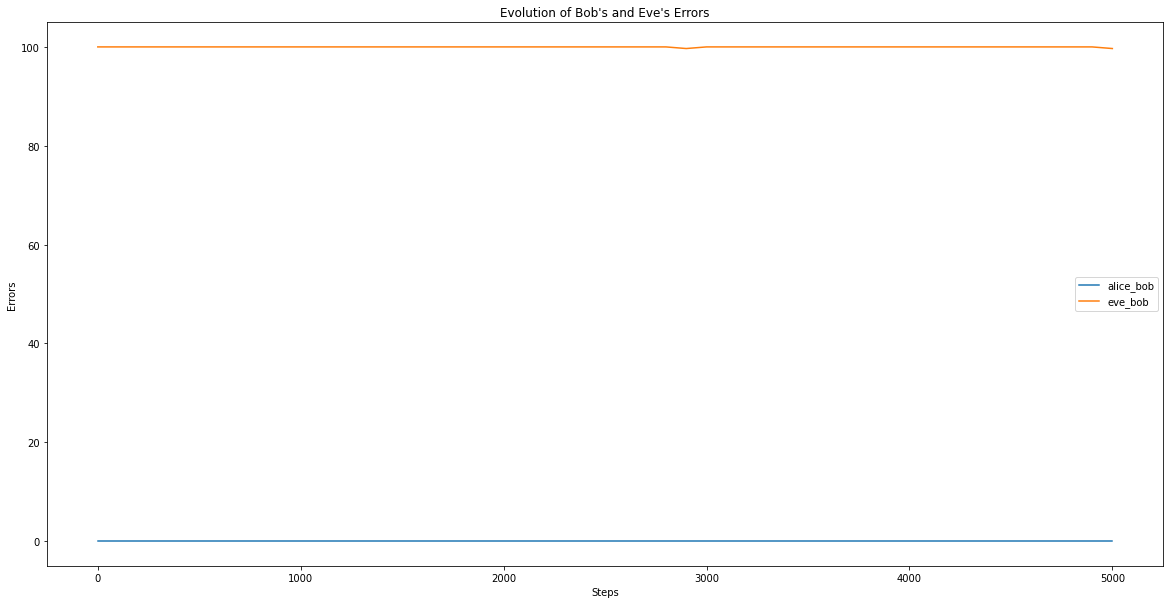

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["alice_bob_vrfy_loss"], label="alice_bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_bob_vrfy_loss"], label="eve_bob")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Errors")

plt.show()

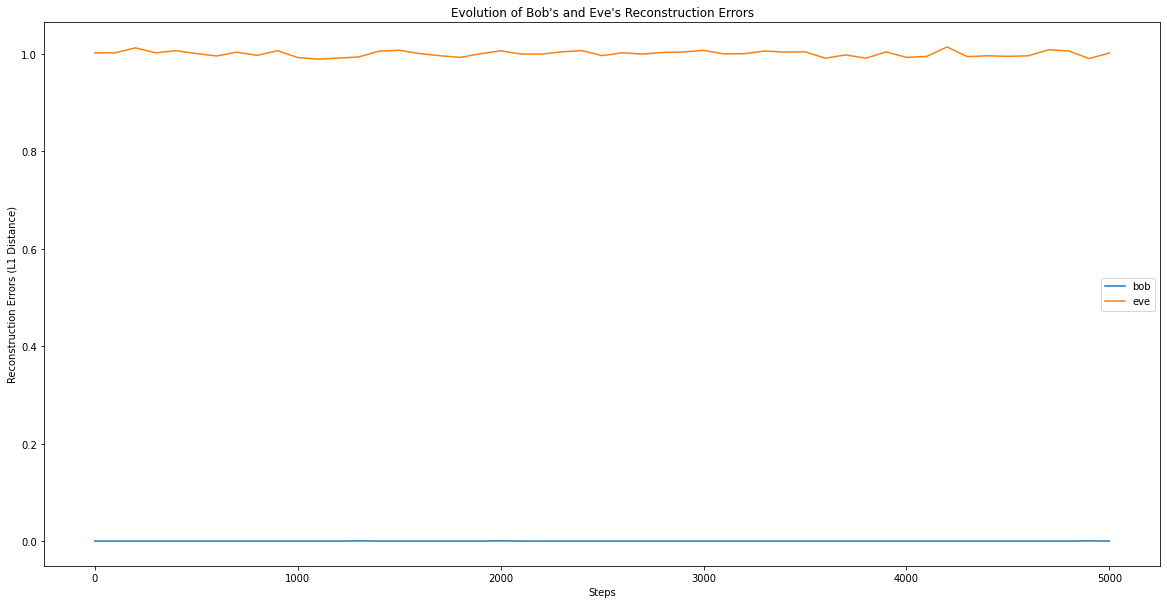

In [20]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(aggregated_losses["step"], aggregated_losses["bob_reconstruction_training_errors"], label="bob")
ax.plot(aggregated_losses["step"], aggregated_losses["eve_reconstruction_training_errors"], label="eve")
ax.legend()
ax.set_title("Evolution of Bob's and Eve's Reconstruction Errors")
ax.set_xlabel("Steps")
ax.set_ylabel("Reconstruction Errors (L1 Distance)")

plt.show()

Next, we infer the models to make the learned authenticated encryption scheme applicable and evaluable. 

In [21]:
def UTF_8_to_binary(m_utf_8):

    # utf-8 -> binary
    # 8 byte unicode for each char in m_utf_8 with spacing in between
    m_bs = " ".join(format(ord(x), "08b") for x in m_utf_8).split(" ")
    return m_bs

In [22]:
import codecs

def binary_to_UTF_8(p_bs):

    # binary string -> ord
    p_ords = [int(p_b, 2) for p_b in p_bs]

    # ord -> hex "0x68"[2:] must slice to be valid hex
    p_hexs = [hex(p_ord)[2:] for p_ord in p_ords]

    # hex -> utf-8
    decoded = "".join([codecs.decode(p_hex.strip(), "hex").decode("utf-8") for p_hex in p_hexs])
    return decoded

In [23]:
import numpy as np
import itertools

def inference(gpu_available, prjPaths):
    
    # declare function member constant
    NUM_BITS_PER_BYTE = 8

    # restore variable to describe message length used to determine network dimensions
    n = restore_persist_object(full_path=os.path.join(prjPaths.PERSIST_DIR, "n.p"))

    # define networks
    alice = Al_MixTransformNN(D_in=(n*3), H=(n*3))
    eve_forge = Al_MixTransformNN(D_in=(n), H=(n*3))
    eve_decr = MixTransformNN(D_in=(2*n), H=(n*4))
    bob_vrfy = Discriminator(D_in=(4*n), H=(4*n))
    bob_decr = MixTransformNN(D_in=(n*4), H=(n*4))

    # restoring persisted networks
    print("restoring all networks...\n")
    alice.load_state_dict(torch.load(os.path.join(prjPaths.CHECKPOINT_DIR, "alice.pth")))
    bob_vrfy.load_state_dict(torch.load(os.path.join(prjPaths.CHECKPOINT_DIR, "bob_vrfy.pth")))
    bob_decr.load_state_dict(torch.load(os.path.join(prjPaths.CHECKPOINT_DIR, "bob_decr.pth")))
    eve_forge.load_state_dict(torch.load(os.path.join(prjPaths.CHECKPOINT_DIR, "eve_forge_2.pth")))
    eve_decr.load_state_dict(torch.load(os.path.join(prjPaths.CHECKPOINT_DIR, "eve_decr_2.pth")))

    # specify that model is currently in training mode
    alice.eval()
    bob_vrfy.eval()
    bob_decr.eval()
    eve_forge.eval()
    eve_decr.eval()

    # if gpu available then run inference on gpu
    if gpu_available:
        alice.cuda()
        bob_vrfy.cuda()
        bob_decr.cuda()
        eve_forge.cuda()
        eve_decr.cuda()

    convert_tensor_to_nblist_and_scale = lambda tensor: list(map(lambda x: round(x, 1), tensor.cpu().detach().numpy().tolist()))
    convert_tensor_to_list_and_scale = lambda tensor: list(map(lambda x: int((round(x)+1)/2), tensor.cpu().detach().numpy().tolist()))
    convert_tensor_to_float = lambda tensor: tensor.cpu().detach().numpy().tolist()

    # fix k
    _, k = generate_data(gpu_available=gpu_available, batch_size=1, n=n)
    ks = "".join(list(map(str, convert_tensor_to_list_and_scale(k[0]))))

    while True:

        m_utf_8 = input("enter plaintext: ")
        if m_utf_8 == '':
            break

        # ensure that p is correct length else pad with spaces (each char 8 bits)
        while not ((len(m_utf_8) * NUM_BITS_PER_BYTE) % n == 0):
            m_utf_8 = m_utf_8 + " "

        # convert p UTF-8 -> Binary
        m_bs = UTF_8_to_binary(m_utf_8)

        print("plaintext \"{}\" in binary: \n                          {}".format(m_utf_8, m_bs))

        # group Binary p into groups that are valid with input layer of network
        # create np array of float datatype for 16 bit (instead of only 8: two chars for one input)
        m_bs = [np.asarray(list(m_bs[i-1]+m_bs[i]), dtype=np.float32) for i, _ in enumerate(m_bs) if ((i-1) * NUM_BITS_PER_BYTE) % n == 0]

        eve_ms_b = []
        bob_ms_b = []
        eve_fs = []
        alice_cs = []
        bob_eve_s = []
        bob_al_s = []
        for m_b in m_bs:
            
            # convert from 0,1 to -1,1
            m_b = torch.unsqueeze(torch.from_numpy(m_b)*2-1, 0)

            if gpu_available:
                m_b = m_b.cuda()

            # run forward pass through networks
            alice_tmp = alice.forward(torch.cat((m_b, k), 1).float())
            alice_c = torch.unsqueeze(alice_tmp.float(), 0)
            alice_c2 = convert_tensor_to_nblist_and_scale(alice_tmp)
            eve_m = convert_tensor_to_list_and_scale(eve_decr.forward(alice_c))
            eve_tmp = eve_forge.forward(m_b)
            eve_f = torch.unsqueeze(eve_tmp.float(), 0)
            eve_f2 = convert_tensor_to_nblist_and_scale(eve_tmp)
            bob_m = convert_tensor_to_list_and_scale(bob_decr.forward(torch.cat((alice_c, k), 1).float()))

            bob_eve_sig = convert_tensor_to_float(bob_vrfy.forward(torch.cat((eve_f, k), 1).float()))
            bob_alice_sig = convert_tensor_to_float(bob_vrfy.forward(torch.cat((alice_c, k), 1).float()))

            alice_cs.append(" ".join(list(map(str, alice_c2))))
            eve_fs.append(" ".join(list(map(str, eve_f2))))
            eve_ms_b.append("".join(list(map(str, eve_m))))
            bob_ms_b.append("".join(list(map(str, bob_m))))
            bob_eve_s.append("".join(str(bob_eve_sig)))
            bob_al_s.append("".join(str(bob_alice_sig)))
        
        print("key:                      {}".format(ks))
        print("alice_cs:                 {}".format(alice_cs))
        print("eve_fs:                   {}".format(eve_fs))
        print("eve_ms_b:                 {}".format(list(itertools.chain.from_iterable([[i[:8], i[8:]]  for i in eve_ms_b]))))
        print("bob_ms_b:                 {}".format(list(itertools.chain.from_iterable([[i[:8], i[8:]]  for i in bob_ms_b]))))
        print("reconstructed text:       \"{}\"".format(binary_to_UTF_8(bob_ms_b)))
        print("bob_eve_s:                {}".format(bob_eve_s))
        print("bob_al_s:                 {}\n".format(bob_al_s))

In [24]:
inference(gpu_available, prjPaths=prjPaths_)

restoring all networks...

plaintext "MoritzWasHere " in binary: 
                          ['01001101', '01101111', '01110010', '01101001', '01110100', '01111010', '01010111', '01100001', '01110011', '01001000', '01100101', '01110010', '01100101', '00100000']
key:                      01101001001110011101010101110111
alice_cs:                 ['-0.6 -0.6 -0.6 -0.5 -0.5 0.8 0.8 -0.1 0.7 -0.4 0.0 -0.3 -0.2 -0.3 0.4 0.3 -0.5 0.2 -0.1 -0.4 0.1 0.3 0.5 -0.4 -0.5 0.3 0.6 0.7 -0.5 -0.6 -0.6 -0.6', '-0.6 -0.6 -0.6 -0.5 0.0 -0.4 -0.5 0.6 0.2 0.4 0.9 -0.3 -0.3 -0.5 -0.3 -0.2 0.5 -0.3 -0.4 0.1 0.7 -0.5 -0.2 -0.2 -0.5 0.7 0.6 0.4 -0.5 -0.6 -0.6 -0.6', '-0.6 -0.6 -0.6 -0.5 -0.5 -0.2 0.3 0.2 0.9 0.2 0.1 0.2 -0.2 0.3 -0.5 -0.2 0.2 -0.2 -0.5 0.8 0.2 -0.1 -0.1 0.2 0.1 0.8 0.3 0.4 -0.5 -0.6 -0.6 -0.6', '-0.6 -0.6 -0.6 -0.5 -0.4 -0.0 0.2 0.3 0.6 -0.2 -0.1 -0.2 -0.3 -0.2 0.5 -0.5 0.8 -0.5 0.3 -0.1 0.9 -0.5 -0.1 -0.5 -0.5 -0.2 0.9 0.1 -0.5 -0.6 -0.6 -0.6', '-0.6 -0.6 -0.6 -0.5 0.6 -0.5 -0.2 0.8 -0.5 0.2 0